# TODO:
- ile potrzeba iteracji (random seach, bayes) do uzyskania stabilncyh wyników - DONE
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy - ADAM -TODO
- używać cross validacjei zamiast zwykłego fit - JANEK -TODO
- określić i przeanalizować tunowalność CAŁYCH algorytmów - DONE
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias) - TODO (zmienaimy seed i patrzymy czy tunowalność się zmienia -> tabelka z 10 seedami i patrzyma jak zmienia się tunowalnosć) -TODO ( przy pisaniu raportu)
- 

### Imports

In [2]:
import itertools
import random
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real

from utills.dataset import load_dataset_from_id, split_dataset
from utills.pipeline import (
    evaluate_pipeline_on_datasets,
    get_bayes_model,
    get_column_transformer,
)

### Utill functions

In [3]:
def get_bayes_config(
    pipeline: Pipeline,
    search_space: Dict[str, Any],
    X: DataFrame,
    y: DataFrame,
    n_iter,
):
    opt: BayesSearchCV = get_bayes_model(pipeline, search_space, n_iter)
    opt.fit(X, y)
    iteration_scores = opt.cv_results_["mean_test_score"]

    # Optional: Print the score for each iteration
    for i, score in enumerate(iteration_scores):
        print(f"Iteration {i + 1}: Score = {score}")
    print("Best score:", opt.best_score_)
    print(opt.n_iter)
    return (dict(opt.best_params_), iteration_scores)

In [4]:
def evaluate_model_performance(
    model: Pipeline, X_train, y_train, X_test, y_test
) -> float:
    model.fit(
        X=X_train,
        y=y_train,
    )
    return model.score(
        X=X_test,
        y=y_test,
    )

In [5]:
def experiment(
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    config,
) -> List[float]:
    performances: List[float] = []
    for (X_train, y_train), (X_test, y_test) in zip(train_datasets, test_datasets):
        model.set_params(**config)
        performance: float = evaluate_model_performance(
            model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
        )
        performances.append(performance)
    return performances

In [6]:
def find_optimal_configuration_for_all_datasets(
    config_space,
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    summary_func,
):
    best_config = None
    best_summary_score = float("0")
    history_scores = []
    for config in config_space:
        performances = experiment(
            train_datasets=train_datasets,
            test_datasets=test_datasets,
            model=model,
            config=config,
        )
        summary_score = summary_func(performances)
        history_scores.append(summary_score)
        if summary_score > best_summary_score:
            best_summary_score = summary_score
            best_config = config

    return (best_config, history_scores)

In [7]:
def find_optimal_config_for_dataset(
    config_space,
    train_dataset: Tuple[DataFrame, Series],
    test_dataset: Tuple[DataFrame, Series],
    model: Pipeline,
):
    best_config = None
    best_score = float("0")

    for config in config_space:
        # model = get_model_func()
        model.set_params(**config)
        score: float = evaluate_model_performance(
            model=model,
            X_train=train_dataset[0],
            y_train=train_dataset[1],
            X_test=test_dataset[0],
            y_test=test_dataset[1],
        )

        if score > best_score:
            best_score = score
            best_config = config

    return best_config

In [8]:
def find_optimal_bayes_config_for_dataset(
    config_space,
    train_dataset: Tuple[DataFrame, Series],
    test_dataset: Tuple[DataFrame, Series],
    pipeline: Pipeline,
    retries: int = 1,
):
    best_config = None
    best_score = float("0")
    steps = -1

    for config in config_space:
        for _ in range(retries):
            cnf = get_bayes_config(pipeline, config, train_dataset[0], train_dataset[1])

            pipeline.set_params(**cnf)
            score: float = evaluate_model_performance(
                model=pipeline,
                X_train=train_dataset[0],
                y_train=train_dataset[1],
                X_test=test_dataset[0],
                y_test=test_dataset[1],
            )

            if score > best_score:
                best_score = score
                best_config = cnf

    return (best_config, steps)

In [9]:
def find_optimal_bayes_config_for_each_dataset(
    config_space,
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    pipeline: Pipeline,
    retries: int = 1,
):
    configs = []
    for train, test in zip(train_datasets, test_datasets):
        cnf = find_optimal_bayes_config_for_dataset(
            config_space, train, test, pipeline, retries
        )
        configs.append(cnf[0])
    return configs

In [37]:
def configs_from_candidates(candidates, pipeline: Pipeline, train_datasets, retries):
    configs = []
    history: List[List[float]] = []
    for train in train_datasets:
        cnf, iteration_scores = get_bayes_config(
            pipeline, candidates[0], train[0], train[1], candidates[1]
        )
        configs.append(cnf)
        history.append(iteration_scores)

    return (configs, history)

### Load datasets

In [11]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
liver_disorders_dataset_id = (
    44994  # https://www.openml.org/search?type=data&id=8&sort=runs&status=active
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)


fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

liver_disorders_dataset: DataFrame = load_dataset_from_id(id=liver_disorders_dataset_id)
liver_disorders_regression_class = "Price"
diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [12]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_liver_disorders,
    X_test_liver_disorders,
    y_train_liver_disorders,
    y_test_liver_disorders,
) = split_dataset(data=liver_disorders_dataset, class_=liver_disorders_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

In [13]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_liver_disorders, y_train_liver_disorders),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
    ]

In [14]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_liver_disorders, y_test_liver_disorders),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
    ]

### TODO: visualize the data

### Create generic column transformer

### Create pipelines

#### 1. Decision Tree

In [15]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [16]:
def get_configuration_grid_decision_tree():
    # parameters space
    random.seed(42)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 200
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

In [17]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
test_datasets: List[Tuple[DataFrame, Series]] = get_test_datasets()
decison_tree_pipeline: Pipeline = get_decision_tree_pipeline()
configuration_grid_decision_tree = get_configuration_grid_decision_tree()

In [18]:
# find teta*

(
    optimal_config_decision_tree,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=configuration_grid_decision_tree,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=decison_tree_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)

In [19]:
print(optimal_config_decision_tree)
print(history_scores)
optimal_decision_tree = get_decision_tree_pipeline()
optimal_decision_tree.set_params(**optimal_config_decision_tree)

{'model__ccp_alpha': 0.4, 'model__max_depth': 17, 'model__min_samples_split': 21, 'model__min_samples_leaf': 6}
[0.6410860728259302, 0.7176368475618518, 0.5671786406325249, 0.630113503694006, 0.6113537246287216, 0.7051375217458019, 0.40104360941919637, 0.5718614760300031, 0.6157315008482871, 0.6761986172426808, 0.5740819280608986, 0.6436335512198272, 0.5740819280608986, 0.5704308617941549, 0.7188305102719654, 0.6537939149510672, 0.6436335512198272, 0.5740819280608986, 0.7188305102719654, 0.58696299124675, 0.5704308617941548, 0.563148782531693, 0.6553176840996273, 0.6882780653718363, 0.6408488039761029, 0.6537939149510672, 0.6290962740310322, 0.5880920922006263, 0.5811817256333549, 0.615883754780877, 0.5996837868133544, 0.40104360941919637, 0.6178225353420752, 0.6394042350987053, 0.6553176840996273, 0.5554653359901104, 0.7163265546680873, 0.628908803459007, 0.6178225353420752, 0.698953889461685, 0.6620157092078246, 0.563148782531693, 0.6142825805489368, 0.5528876311184828, 0.69470917865

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000197106E0B20>),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019710616DC0>)])),
                ('model',
                 DecisionTreeRegressor(ccp_alpha=0.4, max_depth=17,
                                       min_samples_leaf=6,
                                       min_samples_split=21))])

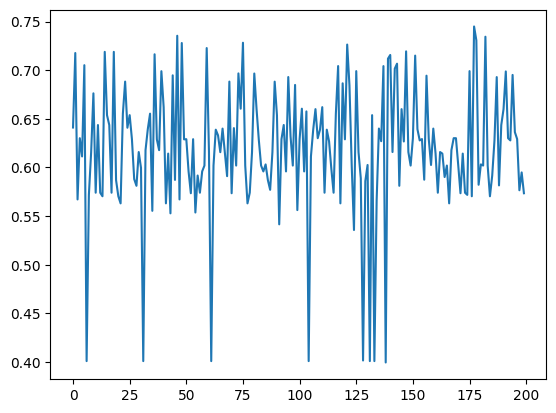

In [20]:
plt.plot(history_scores)

In [21]:
def get_best_configs_for_each_set(
    pipeline: Pipeline, config_space, train_datasets, test_datasets
):
    best_configs = []
    for train_dataset, test_dataset in zip(train_datasets, test_datasets):
        best_config = find_optimal_config_for_dataset(
            config_space=config_space,
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            model=pipeline,
        )
        best_configs.append(best_config)
        pipeline.set_params(**best_config)
        pipeline.fit(train_dataset[0], train_dataset[1])
        print("score: " + str(pipeline.score(test_dataset[0], test_dataset[1])))
        print("best config: " + str(best_config))
    return best_configs

In [22]:
# find tate^(j)*
best_configs_for_each_dataset = get_best_configs_for_each_set(
    pipeline=get_decision_tree_pipeline(),
    config_space=get_configuration_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)

score: 0.9663130950309771
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 6, 'model__min_samples_split': 4, 'model__min_samples_leaf': 6}
score: 0.9487023311889127
best config: {'model__ccp_alpha': 0.9, 'model__max_depth': 11, 'model__min_samples_split': 3, 'model__min_samples_leaf': 3}
score: 0.4692111427031108
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 7, 'model__min_samples_split': 56, 'model__min_samples_leaf': 8}
score: 0.698117764128138
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}


In [23]:
def calculate_tunability_on_each_set(train_datasets, test_datasets, best_configs):
    tunability = []
    for train_dataset, test_dataset, best_config in zip(
        train_datasets, test_datasets, best_configs
    ):
        optimal_decision_tree.fit(train_dataset[0], train_dataset[1])
        best_decision_tree_for_dataset = get_decision_tree_pipeline()
        best_decision_tree_for_dataset.set_params(**best_config)
        best_decision_tree_for_dataset.fit(train_dataset[0], train_dataset[1])
        tunability_on_dataset = best_decision_tree_for_dataset.score(
            test_dataset[0], test_dataset[1]
        ) - optimal_decision_tree.score(test_dataset[0], test_dataset[1])
        tunability.append(tunability_on_dataset)
        print("d^j: " + str(tunability_on_dataset))
    return tunability

In [24]:
# find d^j
tunability_on_datasets = calculate_tunability_on_each_set(
    get_train_datasets(), get_test_datasets(), best_configs_for_each_dataset
)

d^j: 0.019997175361389008
d^j: 0.030792503231530155


d^j: 0.02744406958934731
d^j: 0.024476879843906563


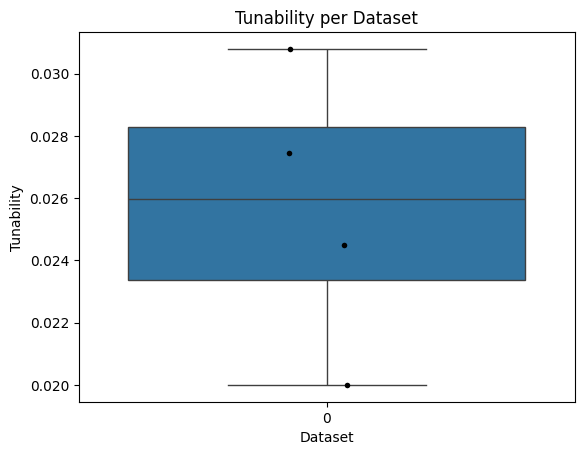

In [25]:
# tunability data
tunability_data = [tunability_on_datasets]

# create box plot
sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset")

# show the plot
plt.show()

In [26]:
# aggregated tunability d
print("Aggregated tunability d: " + str(np.mean(tunability_on_datasets)))

Aggregated tunability d: 0.02567765700654326


In [27]:
def calculate_scores_for_pipeline(pipeline: Pipeline, train_datasets, test_datasets):
    scores = []
    for train_dataset, test_dataset in zip(train_datasets, test_datasets):
        pipeline.fit(train_dataset[0], train_dataset[1])
        score = pipeline.score(test_dataset[0], test_dataset[1])
        scores.append(score)
        print("score: " + str(score))

In [28]:
calculate_scores_for_pipeline(
    optimal_decision_tree, get_train_datasets(), get_test_datasets()
)

score: 0.9463159196695881
score: 0.9179098279573825
score: 0.4417670731137635
score: 0.6736408842842314


Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.7815269691092457
Train score R^2: 0.7815269691092457
Mean Squared Error: 26856.500884781224
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.8229209396151376
Train score R^2: 0.8229209396151376
Mean Squared Error: 16418220.738860969
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.5221465690813645
Train score R^2: 0.5221465690813645
Mean Squared Error: 2903.6276381318785
Parameter set: DecisionTreeRegressor(ccp_alpha=0.2, max_depth=6, min_samples_leaf=19,
                      min_samples_split=58)
Test score R^2: 0.5595820029015193
Train score R^2: 0.5595820029015193


Mean Squared Error: 89991302260.828
Parameter set: DecisionTreeRegressor(max_depth=15, min_samples_leaf=12, min_samples_split=50)
Test score R^2: 0.789919150538415
Train score R^2: 0.789919150538415
Mean Squared Error: 25824.864956727335
Parameter set: DecisionTreeRegressor(max_depth=15, min_samples_leaf=12, min_samples_split=50)
Test score R^2: 0.9056170056801459
Train score R^2: 0.9056170056801459
Mean Squared Error: 8750898.222354084
Parameter set: DecisionTreeRegressor(max_depth=15, min_samples_leaf=12, min_samples_split=50)
Test score R^2: 0.5450218184758296
Train score R^2: 0.5450218184758296
Mean Squared Error: 2764.6285181648223
Parameter set: DecisionTreeRegressor(max_depth=15, min_samples_leaf=12, min_samples_split=50)
Test score R^2: 0.7132709369960079
Train score R^2: 0.7132709369960079
Mean Squared Error: 58587800557.08415
Parameter set: DecisionTreeRegressor(ccp_alpha=0.5, max_depth=13, min_samples_leaf=59,
                      min_samples_split=56)
Test score R^2: 0.619

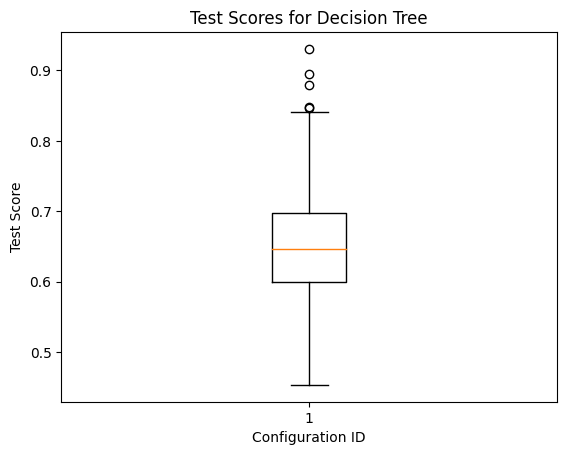

Best Configuration: {'model__ccp_alpha': 0.9, 'model__max_depth': 11, 'model__min_samples_split': 3, 'model__min_samples_leaf': 3}
Best Test Score: 0.9305512355935991


In [29]:
test_scores = (
    []
)  # list of test scores calculated across datasets, for each configuration
config_ids = []
best_config = None
best_test_score = float("-inf")

for i, config in enumerate(configuration_grid_decision_tree):
    results = evaluate_pipeline_on_datasets(
        get_decision_tree_pipeline(), config, train_datasets
    )

    aggregated_test_score = np.mean([result[0] for result in results])
    test_scores.append(aggregated_test_score)
    config_ids.append(i)

    if aggregated_test_score > best_test_score:
        best_test_score = aggregated_test_score
        best_config = config

plt.boxplot(test_scores)
plt.xlabel("Configuration ID")
plt.ylabel("Test Score")
plt.title("Test Scores for Decision Tree")
plt.show()

print("Best Configuration:", best_config)
print("Best Test Score:", best_test_score)

#### Bayes

In [35]:
def get_bayes_config_candidates_decision_tree():
    return (
        {
            "model__ccp_alpha": Real(0.0, 1.0),
            "model__max_depth": Integer(1, 30),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 60),
        },
        30,
    )

In [38]:
candidates = get_bayes_config_candidates_decision_tree()
np.int = np.int64
# calculate all configs
configs, history = configs_from_candidates(
    candidates=candidates,
    pipeline=get_decision_tree_pipeline(),
    train_datasets=get_train_datasets(),
    retries=1,
)

Iteration 1: Score = 0.7913990245351916
Iteration 2: Score = 0.636255581318055
Iteration 3: Score = 0.9389012378055414
Iteration 4: Score = 0.6465515830899411
Iteration 5: Score = 0.7860359131759462
Iteration 6: Score = 0.7798188215781269
Iteration 7: Score = 0.7353508021251304
Iteration 8: Score = 0.7894606626561915
Iteration 9: Score = -0.05320919309927987
Iteration 10: Score = 0.7913990245351916
Iteration 11: Score = 0.6938644238320535
Iteration 12: Score = 0.8751556237318681
Iteration 13: Score = 0.965736664696081
Iteration 14: Score = 0.6938644238320535
Iteration 15: Score = 0.912913149157968
Iteration 16: Score = 0.9113998260383278
Iteration 17: Score = 0.9637881287384001
Iteration 18: Score = 0.6768848582044329
Iteration 19: Score = 0.8855628093449461
Iteration 20: Score = 0.7819467475731763
Iteration 21: Score = 0.9660522408342699
Iteration 22: Score = 0.9629801306268229
Iteration 23: Score = 0.7772948803981256
Iteration 24: Score = 0.7862352697558779
Iteration 25: Score = 0.69

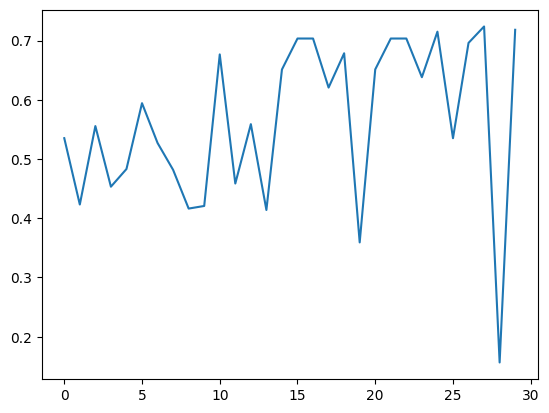

In [42]:
plt.plot(history[3])

In [ ]:
# find optimal theta

(
    optimal_config,
    last_idx_of_config_with_significant_improvement,
) = find_optimal_configuration_for_all_datasets(
    config_space=configs,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=get_decision_tree_pipeline(),
    summary_func=np.mean,
)

In [ ]:
from sklearn.model_selection import cross_val_score

# Calculate cross-validation score
pipeline = get_decision_tree_pipeline()
pipeline.set_params(**configs[1])
pipeline.fit(get_train_datasets()[1][0], get_train_datasets()[1][1])
cv_scores = cross_val_score(
    pipeline, get_train_datasets()[1][0], get_train_datasets()[1][1], cv=2
)


# Print the mean cross-validation score
print("Mean Cross-Validation Score:", cv_scores.mean())
print(
    "score: witht out bayes: "
    + str(pipeline.score(get_train_datasets()[1][0], get_train_datasets()[1][1]))
)

Mean Cross-Validation Score: 0.8751819581162275
score: witht out bayes: 0.9603564848108909


In [ ]:
print(optimal_config)
print(last_idx_of_config_with_significant_improvement)
optimal_decision_tree = get_decision_tree_pipeline()
optimal_decision_tree.set_params(**optimal_config_decision_tree)

In [ ]:
# find theta^(j)
best_configs_for_each_dataset = get_best_configs_for_each_set(
    pipeline=get_decision_tree_pipeline(),
    config_space=configs,
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)

In [ ]:
# find d^j
tunability_on_datasets = calculate_tunability_on_each_set(
    get_train_datasets(), get_test_datasets(), best_configs_for_each_dataset
)

In [ ]:
# tunability data
tunability_data = [tunability_on_datasets]

# create box plot
sns.boxplot(data=tunability_data)

# add strip plot
sns.stripplot(data=tunability_data, color="black", size=4)

# add labels and title
plt.xlabel("Dataset")
plt.ylabel("Tunability")
plt.title("Tunability per Dataset")

# show the plot
plt.show()

#### 2. ElasticNet

In [ ]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [ ]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(42)
    alpha = [i * 0.05 for i in range(21)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
elastic_net_pipeline: Pipeline = get_elasticnet_pipeline()
parameters_grid_elasticnet = get_parameter_grid_for_elasticnet()
optimal_config_elasticnet = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_elasticnet,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=elastic_net_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_elasticnet)

In [ ]:
evaluate_pipeline_on_datasets(
    get_elasticnet_pipeline(), optimal_config_elasticnet, train_datasets
)

#### 3. Random Forest

In [ ]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [ ]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(42)
    max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 61, 1)
    min_samples_leaf_values = range(1, 61, 1)
    n_estimators_values = range(1, 200, 1)

    all_combinations = list(
        itertools.product(
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
random_forest_pipeline: Pipeline = get_random_forest_pipeline()
parameters_grid_random_forest = get_parameter_grid_for_random_forest()

optimal_config_random_forest = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_random_forest,
    train_datasets=train_datasets,
    model=random_forest_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_random_forest)

In [ ]:
evaluate_pipeline_on_datasets(
    get_random_forest_pipeline(), optimal_config_random_forest, train_datasets
)

#TODO
- dla każdej konfiguracje z paratmers_grid trzeba ją porównać do optymalnej

### Bayes - decision tree

In [ ]:
decision_tree_params = {
    "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
    "model__max_depth": Integer(1, 31, prior="log-uniform"),
    "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
    "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
}

In [ ]:
config = get_bayes_config(
    get_decision_tree_pipeline(),
    [(decision_tree_params, 40)],
    X_train_fish_market,
    y_train_fish_market,
)
model = get_decision_tree_pipeline()
model.set_params(**config)
model.fit(X_train_fish_market, y_train_fish_market)
score = model.score(X_test_fish_market, y_test_fish_market)
print(score)